Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Redes Neurais Recorrentes Bidirecionais
:label:`sec_bi_rnn`

No aprendizado sequencial,
até agora, assumimos que nosso objetivo é modelar a próxima saída, dado o que vimos até agora, por exemplo, no contexto de uma série temporal ou no contexto de um modelo de linguagem. Embora este seja um cenário típico, não é o único que podemos encontrar. Para ilustrar o problema, considere as três tarefas a seguir para preencher o espaço em branco em uma sequência de texto:

* Eu estou`___`.
* Eu estou `___` faminto.
* Eu estou `___` faminto, e poderia comer meio porco.

Dependendo da quantidade de informações disponíveis, podemos preencher os espaços em branco com palavras muito diferentes, como "feliz", "não" e "muito".
Claramente, o final da frase (se disponível) transmite informações significativas sobre qual palavra escolher.
Um modelo de sequência que é incapaz de tirar vantagem disso terá um desempenho ruim em tarefas relacionadas.
Por exemplo, para se sair bem no reconhecimento de entidade nomeada (por exemplo, para reconhecer se "Verde" se refere a "Sr. Verde" ou à cor)
contexto de longo alcance é igualmente vital.
Para obter alguma inspiração para abordar o problema, façamos um desvio para modelos gráficos probabilísticos.


## Programação dinâmica em modelos de Markov ocultos

Esta subseção serve para ilustrar o problema de programação dinâmica. Os detalhes técnicos específicos não importam para a compreensão dos modelos de aprendizagem profunda
mas ajudam a motivar por que se pode usar o aprendizado profundo e por que se pode escolher arquiteturas específicas.

Se quisermos resolver o problema usando modelos gráficos probabilísticos, poderíamos, por exemplo, projetar um modelo de variável latente como segue.
A qualquer momento, passo $t$,
assumimos que existe alguma variável latente $h_t$ que governa nossa emissão observada $x_t$ via $P(x_t \mid h_t)$.
Além disso, qualquer transição $h_t \to h_{t+1}$ é dada por alguma probabilidade de transição de estado $P(h_{t+1} \mid h_{t})$. Este modelo gráfico probabilístico é então um *modelo Markov oculto* como em :numref: =`fig_hmm`.

![Um modelo de Markov oculto.](../img/hmm.svg)
:label:`fig_hmm`

Desse modo,
para uma sequência de observações $T$, temos a seguinte distribuição de probabilidade conjunta sobre os estados observados e ocultos:

$$P(x_1, \ldots, x_T, h_1, \ldots, h_T) = \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t), \text{ onde} P(h_1 \mid h_0) = P(h_1).$$
:eqlabel:`eq_hmm_jointP`

Agora suponha que observamos todos os $x_i$ com exceção de alguns $x_j$ e nosso objetivo é calcular $P(x_j \mid x_{-j})$, onde $x_{-j} = (x_1, \ldots, x_{j-1}, x_{j+1}, \ldots, x_{T})$.
Uma vez que não há variável latente
em $P(x_j \mid x_{-j})$,
nós consideramos resumir
todas as combinações possíveis de escolhas para $h_1, \ldots, h_T$.
No caso de qualquer $h_i$ poder assumir valores distintos de $k$ (um número finito de estados), isso significa que precisamos somar mais de $k^T$ termos --- normalmente missão impossível! Felizmente, existe uma solução elegante para isso: *programação dinâmica*.

Para ver como funciona,
considere somar as variáveis latentes
$h_1, \ldots, h_T$ por sua vez.
De acordo com :eqref:`eq_hmm_jointP`,
isso produz:

$$\begin{aligned}
    &P(x_1, \ldots, x_T) \\
    =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_2, \ldots, h_T} \underbrace{\left[\sum_{h_1} P(h_1) P(x_1 \mid h_1) P(h_2 \mid h_1)\right]}_{\pi_2(h_2) \stackrel{\mathrm{def}}{=}}
    P(x_2 \mid h_2) \prod_{t=3}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_3, \ldots, h_T} \underbrace{\left[\sum_{h_2} \pi_2(h_2) P(x_2 \mid h_2) P(h_3 \mid h_2)\right]}_{\pi_3(h_3)\stackrel{\mathrm{def}}{=}}
    P(x_3 \mid h_3) \prod_{t=4}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t)\\
    =& \dots \\
    =& \sum_{h_T} \pi_T(h_T) P(x_T \mid h_T).
\end{aligned}$$

Em geral, temos a *recursão direta* como

$$\pi_{t+1}(h_{t+1}) = \sum_{h_t} \pi_t(h_t) P(x_t \mid h_t) P(h_{t+1} \mid h_t).$$

A recursão é inicializada como $\pi_1(h_1) = P(h_1)$. Em termos abstratos, isso pode ser escrito como $\pi_{t+1} = f(\pi_t, x_t)$, onde $f$ é alguma função aprendível. Isso se parece muito com a equação de atualização nos modelos de variáveis latentes que discutimos até agora no contexto de RNNs!

De forma totalmente análoga à recursão direta,
nós também podemos
soma sobre o mesmo conjunto de variáveis latentes com uma recursão para trás. Isso produz:

$$\begin{aligned}
    & P(x_1, \ldots, x_T) \\
     =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot P(h_T \mid h_{T-1}) P(x_T \mid h_T) \\
    =& \sum_{h_1, \ldots, h_{T-1}} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_T} P(h_T \mid h_{T-1}) P(x_T \mid h_T)\right]}_{\rho_{T-1}(h_{T-1})\stackrel{\mathrm{def}}{=}} \\
    =& \sum_{h_1, \ldots, h_{T-2}} \prod_{t=1}^{T-2} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_{T-1}} P(h_{T-1} \mid h_{T-2}) P(x_{T-1} \mid h_{T-1}) \rho_{T-1}(h_{T-1}) \right]}_{\rho_{T-2}(h_{T-2})\stackrel{\mathrm{def}}{=}} \\
    =& \ldots \\
    =& \sum_{h_1} P(h_1) P(x_1 \mid h_1)\rho_{1}(h_{1}).
\end{aligned}$$

Podemos, portanto, escrever a *recursão para trás* como

$$\rho_{t-1}(h_{t-1})= \sum_{h_{t}} P(h_{t} \mid h_{t-1}) P(x_{t} \mid h_{t}) \rho_{t}(h_{t}),$$

com inicialização $\rho_T(h_T) = 1$. 
Ambas as recursões para frente e para trás nos permitem somar mais de $T$ variáveis latentes em $\mathcal{O}(kT)$ (linear) tempo sobre todos os valores de $(h_1, \ldots, h_T)$ em vez de em tempo exponencial .
Este é um dos grandes benefícios da inferência probabilística com modelos gráficos.
Isto é
também uma instância muito especial de
um algoritmo geral de passagem de mensagens :cite:`Aji.McEliece.2000`.
Combinando recursões para frente e para trás, somos capazes de calcular

$$P(x_j \mid x_{-j}) \propto \sum_{h_j} \pi_j(h_j) \rho_j(h_j) P(x_j \mid h_j).$$

Observe que, em termos abstratos, a recursão para trás pode ser escrita como $\rho_{t-1} = g(\rho_t, x_t)$, onde $g$ é uma função que pode ser aprendida. Novamente, isso se parece muito com uma equação de atualização, apenas rodando para trás, ao contrário do que vimos até agora em RNNs. Na verdade, os modelos ocultos de Markov se beneficiam do conhecimento de dados futuros, quando estiverem disponíveis. Os cientistas de processamento de sinais distinguem entre os dois casos de conhecimento e não conhecimento de observações futuras como interpolação vs. extrapolação.
Veja o capítulo introdutório do livro sobre algoritmos sequenciais de Monte Carlo para mais detalhes :cite:`Doucet.De-Freitas.Gordon.2001`.


## Modelo Bidirecional

Se quisermos ter um mecanismo em RNNs que ofereça capacidade de antecipação comparável aos modelos de Markov ocultos, precisamos modificar o projeto RNN que vimos até agora. Felizmente, isso é fácil conceitualmente. Em vez de executar um RNN apenas no modo de encaminhamento a partir do primeiro token, iniciamos outro a partir do último token executado de trás para a frente.
*RNNs bidirecionais* adicionam uma camada oculta que transmite informações para trás para processar essas informações com mais flexibilidade. :numref:`fig_birnn` ilustra a arquitetura de um RNN bidirecional com uma única camada oculta.

![Arquitetura de RNN bidirecional.](../img/birnn.svg)
:label:`fig_birnn`

Na verdade, isso não é muito diferente das recursões para frente e para trás na programação dinâmica de modelos ocultos de Markov.
A principal diferença é que no caso anterior essas equações tinham um significado estatístico específico.
Agora eles estão desprovidos de tais interpretações facilmente acessíveis e podemos apenas tratá-los como
funções genéricas e aprendíveis.
Essa transição resume muitos dos princípios que orientam o projeto de redes profundas modernas: primeiro, use o tipo de dependências funcionais dos modelos estatísticos clássicos e, em seguida, os parametrize de uma forma genérica.


### Definição

RNNs bidirecionais foram introduzidos por :cite:`Schuster.Paliwal.1997`.
Para uma discussão detalhada das várias arquiteturas, consulte também o artigo :cite:`Graves.Schmidhuber.2005`.
Vejamos as especificidades dessa rede.

Para qualquer etapa de tempo $t$,
dado um minibatch input $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (número de exemplos: $n$, número de entradas em cada exemplo: $d$) e deixe o oculto a função de ativação da camada seja $\phi$. Na arquitetura bidirecional, assumimos que os estados ocultos para frente e para trás para este intervalo de tempo são  $\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ e $\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$, respectivamente,
onde $h$ é o número de unidades ocultas.
As atualizações de estado oculto para frente e para trás são as seguintes:

$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}),
\end{aligned}
$$

onde os pesos $\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}, \text{ and } \mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{h \times h}$, e vieses $\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h} \text{ and } \mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$ são todos os parâmetros do modelo.

A seguir, concatenamos os estados ocultos para frente e para trás $\overrightarrow{\mathbf{H}}_t$ e $\overleftarrow{\mathbf{H}}_t$
para obter o estado oculto $\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$ para alimentar a camada de saída.
Em RNNs bidirecionais profundos com várias camadas ocultas,
tal informação
é passado como *entrada* para a próxima camada bidirecional. Por último, a camada de saída calcula a saída $\mathbf{O}_t \in \mathbb{R}^{n \times q}$ (número de saídas: $q$):

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

Aqui, a matriz de peso $\mathbf{W}_{hq} \in \mathbb{R}^{2h \times q}$ e o viés $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ são os parâmetros do modelo da camada de saída. Na verdade, as duas direções podem ter diferentes números de unidades ocultas.

### Custo computacional e aplicativos

Uma das principais características de um RNN bidirecional é que as informações de ambas as extremidades da sequência são usadas para estimar a saída. Ou seja, usamos informações de observações futuras e passadas para prever a atual.
No caso da previsão do próximo token, isso não é bem o que desejamos.
Afinal, não podemos nos dar ao luxo de saber o próximo token ao prever o próximo. Portanto, se fôssemos usar um RNN bidirecional ingenuamente, não obteríamos uma precisão muito boa: durante o treinamento, temos dados passados ​​e futuros para estimar o presente. Durante o tempo de teste, temos apenas dados anteriores e, portanto, pouca precisão. Vamos ilustrar isso em um experimento abaixo.

Para piorar a situação, os RNNs bidirecionais também são excessivamente lentos.
As principais razões para isso são que
a propagação para a frente
requer recursões para frente e para trás
em camadas bidirecionais
e que a retropropagação depende dos resultados da propagação direta. Portanto, os gradientes terão uma cadeia de dependência muito longa.

Na prática, as camadas bidirecionais são usadas com muito moderação e apenas para um conjunto estreito de aplicações, como preencher palavras que faltam, tokens de anotação (por exemplo, para reconhecimento de entidade nomeada) e sequências de codificação por atacado como uma etapa em um pipeline de processamento de sequência (por exemplo, para tradução automática).
Em :numref:`sec_bert` e :numref:`sec_sentiment_rnn`,
apresentaremos como usar RNNs bidirecionais
para codificar sequências de texto.

## Treinar um RNN bidirecional para uma aplicação errada

Se ignorarmos todos os conselhos sobre o fato de que RNNs bidirecionais usam dados passados e futuros e simplesmente os aplicam a modelos de linguagem,
obteremos estimativas com perplexidade aceitável. No entanto, a capacidade do modelo de prever tokens futuros está seriamente comprometida, conforme ilustra o experimento abaixo.
Apesar da perplexidade razoável, ele só gera rabiscos mesmo depois de muitas iterações.
Incluímos o código abaixo como um exemplo de advertência contra usá-los no contexto errado.


perplexity 1.1, 110977.8 tokens/sec on cuda:0
time travellerererererererererererererererererererererererererer


travellerererererererererererererererererererererererererer


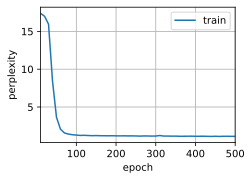

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# Load data
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# Define the bidirectional LSTM model by setting `bidirectional=True`
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# Train the model
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

O resultado é claramente insatisfatório pelos motivos descritos acima.
Para
discussão de usos mais eficazes de RNNs bidirecionais, consulte o sentimento
aplicação de análise
em :numref:`sec_sentiment_rnn`.

## Sumário

* Em RNNs bidirecionais, o estado oculto para cada intervalo de tempo é simultaneamente determinado pelos dados antes e depois do intervalo de tempo atual.
* Os RNNs bidirecionais apresentam uma semelhança notável com o algoritmo para frente e para trás em modelos gráficos probabilísticos.
* RNNs bidirecionais são mais úteis para codificação de sequência e estimativa de observações em contexto bidirecional.
* RNNs bidirecionais são muito caros para treinar devido às longas cadeias de gradiente.

## Exercícios

1. Se as diferentes direções usarem um número diferente de unidades ocultas, como a forma de $\mathbf{H}_t$ mudará?
1. Projete um RNN bidirecional com várias camadas ocultas.
1. A polissemia é comum em línguas naturais. Por exemplo, a palavra "banco" tem significados diferentes em contextos “fui ao banco para depositar dinheiro” e “fui ao banco para me sentar”. Como podemos projetar um modelo de rede neural de modo que, dada uma sequência de contexto e uma palavra, uma representação vetorial da palavra no contexto seja retornada? Que tipo de arquitetura neural é preferida para lidar com a polissemia?


[Discussão](https://discuss.d2l.ai/t/1059)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTcxMzMyMDA5NCwtMzMyNzEyMjI3LC01Mz
U0Nzg0MTNdfQ==
-->
